# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import torch
import numpy as np
from collections import namedtuple, deque
from ddpg_agent import Agent


import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Traing the agent


In [5]:
BATCH_SIZE = 128        # minibatch size
BUFFER_SIZE = int(1e6)  # replay buffer size
GAMMA = 0.99            # discount factor
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
TAU = 6e-2              # for soft update of target parameters


In [6]:
agent_0 = Agent(0, state_size, action_size, gamma=GAMMA, tau=TAU, replay_buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC)
agent_1 = Agent(1, state_size, action_size, gamma=GAMMA, tau=TAU, replay_buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC)

In [7]:
def act (states, eps=1, add_noise=True):
    # each agent selects an action
    action_0 = agent_0.act(states, eps)           
    action_1 = agent_1.act(states, eps)
        
    # combine actions and...
    actions = np.concatenate((action_0, action_1), axis=0) 
    actions = np.reshape(actions, (1, action_size*num_agents))
    return actions

def step (states, actions, rewards, next_states, done):
    # let agents step
    agent_0.step(states, actions, rewards[0], next_states, done) 
    agent_1.step(states, actions, rewards[1], next_states, done) 
    

def train(n_episodes=2000, eps=5, eps_end=0.01, eps_decay=0.997, solve_score=0.5): 
    all_scores = []
    scores_window = deque(maxlen=100)
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations
        states = np.reshape(states, (1, state_size*num_agents))
        agent_0.reset()
        agent_1.reset()
        scores = np.zeros(num_agents)
        while True:

            actions = act(states, eps)

            # send them to environment
            env_info = env.step(actions)[brain_name]

            # merge next states into one state space
            next_states = np.reshape(env_info.vector_observations, (1, state_size*num_agents))     

            rewards = env_info.rewards                         
            done = env_info.local_done    

            step(states, actions, rewards, next_states, done)

            scores += rewards                                  
            states = next_states                               

            if np.any(done):                                  
                break

        # for each episode
        eps = max(eps_end, eps*eps_decay)
        scores_window.append(np.max(scores))
        all_scores.append(np.max(scores))

        if i_episode % 10 == 0:
            print('Episode {}\tAverage Reward: {:.3f}'.format(i_episode, np.mean(scores_window)))

        if np.mean(scores_window) >= solve_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(
                i_episode-100, np.mean(scores_window)))
            torch.save(agent_0.actor_local.state_dict(), 'actor_0.pth')
            torch.save(agent_0.critic_local.state_dict(), 'critic_0.pth')
            torch.save(agent_1.actor_local.state_dict(), 'actor_1.pth')
            torch.save(agent_1.critic_local.state_dict(), 'critic_1.pth')
            break

    return all_scores    

In [8]:
scores = train(eps=8, solve_score=1.0);

Episode 10	Average Reward: 0.000
Episode 20	Average Reward: 0.005
Episode 30	Average Reward: 0.006
Episode 40	Average Reward: 0.007
Episode 50	Average Reward: 0.008
Episode 60	Average Reward: 0.009
Episode 70	Average Reward: 0.009
Episode 80	Average Reward: 0.010
Episode 90	Average Reward: 0.011
Episode 100	Average Reward: 0.011
Episode 110	Average Reward: 0.011
Episode 120	Average Reward: 0.012
Episode 130	Average Reward: 0.013
Episode 140	Average Reward: 0.012
Episode 150	Average Reward: 0.012
Episode 160	Average Reward: 0.012
Episode 170	Average Reward: 0.013
Episode 180	Average Reward: 0.016
Episode 190	Average Reward: 0.017
Episode 200	Average Reward: 0.017
Episode 210	Average Reward: 0.020
Episode 220	Average Reward: 0.021
Episode 230	Average Reward: 0.022
Episode 240	Average Reward: 0.025
Episode 250	Average Reward: 0.027
Episode 260	Average Reward: 0.032
Episode 270	Average Reward: 0.032
Episode 280	Average Reward: 0.032
Episode 290	Average Reward: 0.030
Episode 300	Average Rew

### 4. Plot training episodes


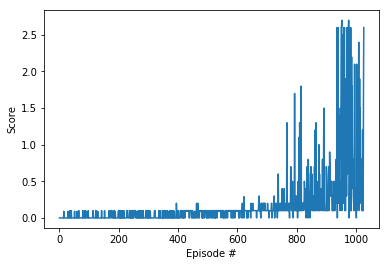

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch agents play tennis


In [10]:
def play (num_episodes=1000): 
    agent_0.actor_local.load_state_dict(torch.load('actor_0.pth'))
    agent_0.critic_local.load_state_dict(torch.load('critic_0.pth'))

    agent_1.actor_local.load_state_dict(torch.load('actor_1.pth'))
    agent_1.critic_local.load_state_dict(torch.load('critic_1.pth'))

    env_info = env.reset(train_mode=False)[brain_name]        
    states = env_info.vector_observations
    states = np.reshape(states, (1, state_size*num_agents))

    for i in range(num_episodes):
        actions = act(states, add_noise=False)
        env_info = env.step(actions)[brain_name]
        next_states = np.reshape(env_info.vector_observations, (1, state_size*num_agents))
        rewards = env_info.rewards                         
        done = env_info.local_done    
        step(states, actions, rewards, next_states, done)
        states = next_states                               

In [ ]:
play()

In [ ]:
env.close()